# Reference: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#exercises

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import os
import time

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import gc
from tqdm import tqdm
import math
tqdm.pandas()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')
device

device(type='cuda')

## Load Data

In [2]:
start = time.time()

if os.path.isfile('./data/valid_subset.csv'):
    # cleaned, filtered by length, 10% dataset
    df = pd.read_csv('./data/valid_subset.csv', index_col=False)
    
elif os.path.isfile('./data/valid_cleaned_data.csv'):
    # cleaned, filtered by length dataset
    df = pd.read_csv('./data/valid_cleaned_data.csv', index_col=False)
    
elif os.path.isfile('./data/cleaned_data.csv'):
    # cleaned dataset
    df = pd.read_csv('./data/cleaned_data.csv', index_col=False)
else:

    df = pd.read_csv('./data/en-fr.csv')

end = time.time()
display(end - start)

df.head()

0.3772156238555908

,en,fr
0,another easily recognizable form of ar technol...,une autre forme connue de ra est l ecran de vi...
1,however since sao paulo is a big and scattered...,cependant comme sao paulo est une grande ville...
2,this provision provides among other things tha...,cette provision prevoit notamment qu une deduc...
3,where would you expect to find a document that...,ou crois tu que tu trouveras un document qui t...
4,at the request of agency staff additional comm...,a la demande du personnel de l office royal a ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146993 entries, 0 to 146992
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   en      146993 non-null  object
 1   fr      146993 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB


## Clean the data

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [5]:
# Clean data only if not available    

start = time.time()
df.dropna(inplace=True)

if not os.path.isfile('./data/cleaned_data.csv'):
    df['en'] = df['en'].apply(lambda x: normalizeString(str(x)))
    df['fr'] = df['fr'].apply(lambda x: normalizeString(str(x)))
    df.to_csv('./data/cleaned_data.csv', index=False)
    
end = time.time()
display(end-start)

0.023172616958618164

In [6]:
### Example sentence length
if not os.path.isfile('./data/cleaned_data.csv'):
    df['en_len'] = df.progress_apply(lambda row: len(row['en'].split(' ')), axis=1)
    df['fr_len'] = df.progress_apply(lambda row: len(row['fr'].split(' ')), axis=1)
df

,en,fr
0,another easily recognizable form of ar technol...,une autre forme connue de ra est l ecran de vi...
1,however since sao paulo is a big and scattered...,cependant comme sao paulo est une grande ville...
2,this provision provides among other things tha...,cette provision prevoit notamment qu une deduc...
3,where would you expect to find a document that...,ou crois tu que tu trouveras un document qui t...
4,at the request of agency staff additional comm...,a la demande du personnel de l office royal a ...
...,...,...
146988,it would be most beneficial and effective for ...,il serait tres avantageux et efficace pour le ...
146989,cost reductions particular importance shall be...,reductions des couts une importance particulie...
146990,this inconsistent approach to marking had sign...,cette methode de cotation non uniforme a eu de...
146991,testimony of lgen gervais transcripts vol,temoignage du lgne gervais transcriptions vol


In [7]:
if not os.path.isfile('./data/cleaned_data.csv'):
    display(df['en_len'].quantile(0.8))
    display(df['fr_len'].quantile(0.7))

In [8]:
### Filter dataset by length
MAX_LENGTH = 35

if not os.path.isfile('./data/valid_cleaned_data.csv'):
    df['en_len'] = df['en'].apply(lambda sent: len(sent.split(" ")))
    df['fr_len'] = df['fr'].apply(lambda sent: len(sent.split(" ")))

    df = df[df['en_len'] < MAX_LENGTH]
    df = df[df['fr_len'] < MAX_LENGTH]
    
    df = df[['en', 'fr']]
    
    df.to_csv('./data/valid_cleaned_data.csv', index=False)


df

,en,fr
0,another easily recognizable form of ar technol...,une autre forme connue de ra est l ecran de vi...
1,however since sao paulo is a big and scattered...,cependant comme sao paulo est une grande ville...
2,this provision provides among other things tha...,cette provision prevoit notamment qu une deduc...
3,where would you expect to find a document that...,ou crois tu que tu trouveras un document qui t...
4,at the request of agency staff additional comm...,a la demande du personnel de l office royal a ...
...,...,...
146988,it would be most beneficial and effective for ...,il serait tres avantageux et efficace pour le ...
146989,cost reductions particular importance shall be...,reductions des couts une importance particulie...
146990,this inconsistent approach to marking had sign...,cette methode de cotation non uniforme a eu de...
146991,testimony of lgen gervais transcripts vol,temoignage du lgne gervais transcriptions vol


In [9]:
### Prepare only subset of data
frac = 0.1

if not os.path.isfile('./data/valid_subset.csv'):
    df_subset = df.sample(frac=frac)
    df_subset.to_csv('./data/valid_subset.csv', index=False)
else:
    df_subset = df

df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146993 entries, 0 to 146992
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   en      146993 non-null  object
 1   fr      146993 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB


In [10]:
df_subset[df_subset.isna().any(axis=1)]

,en,fr


## Create helpers to construct vocabulary

In [30]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [31]:
len(df_subset)

146993

## Preparing Data for training

In [32]:
gc.collect()
#df_small = df_subset.sample(frac=0.1)


# This function takes in the sentence pair dataframe and create the language vocabularies
def prepareData(df):
    en_lang = Lang('en')
    fr_lang = Lang('fr')
    
    en_vocab = []
    fr_vocab = []
    
    for index, row in tqdm(df.iterrows(), total=df.shape[0], position=0, leave=True):
        en_sent = row['en']
        fr_sent = row['fr']
        
        en_vocab += en_sent.split(" ")
        fr_vocab += fr_sent.split(" ")
        
    
    # Construct word2index and index2word dicts for the two languages
    en_vocab = set(en_vocab)
    fr_vocab = set(fr_vocab)
    
    en_word2index = dict([(word, i+2) for i, word in enumerate(en_vocab)])
    fr_word2index = dict([(word, i+2) for i, word in enumerate(fr_vocab)])
    
    en_index2word = {v: k for k, v in en_word2index.items()}
    fr_index2word = {v: k for k, v in fr_word2index.items()}
    
    en_lang.word2index = en_word2index
    fr_lang.word2index = fr_word2index
    
    en_lang.index2word.update(en_index2word)
    fr_lang.index2word.update(fr_index2word)
    
    en_lang.n_words = len(en_lang.index2word.keys())
    fr_lang.n_words = len(fr_lang.index2word.keys())
    
    return en_lang, fr_lang
        

start = time.time()
en_lang, fr_lang = prepareData(df_subset)
end = time.time() 
display(end - start)



100%|██████████| 146993/146993 [00:05<00:00, 24920.27it/s]


6.47471284866333

In [33]:
df_train = df_subset.sample(frac=0.75)

df_test = pd.concat([df_subset, df_train])
df_test.drop_duplicates(keep=False, inplace=True)
df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

df_test

,en,fr
0,this provision provides among other things tha...,cette provision prevoit notamment qu une deduc...
1,does historical conflict disappear when its ph...,est ce que les conflits de l histoire se disso...
2,i firmly believe firefighters police paramedic...,je crois fermement que les pompiers policiers ...
3,short term interest rates have moved up re ect...,la bande represente la fourchette visee par la...
4,a substantial amount of effort is devoted to m...,des efforts considerables sont consacres a l e...
...,...,...
36711,in addition to federal income tax such individ...,en plus de l impot federal sur le revenu ces p...
36712,date and place of next meeting monday th may f...,date et lieu de la prochaine reunion lundi mai...
36713,a qualitative investigation of barriers to car...,une appreciation qualitative des obstacles a l...
36714,wildlife must move about to find food water an...,les especes sauvages doivent se deplacer a la ...


In [34]:
# helper function that turns sentenceeinto list of token index in the language vocabulary
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] if word in lang.word2index.keys() else 0 for word in sentence.split(' ')]

# create pytorch dataloader from the sentence pair dataframe
def get_dataloader(batch_size, en_lang, fr_lang, df):
    
    n = len(df)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    
    
    for idx, row in tqdm(df.iterrows(), total=n, position=0, leave=True):
        en_sent = row[en_lang.name]
        fr_sent = row[fr_lang.name]
        
        en_ids = indexesFromSentence(en_lang, en_sent)
        fr_ids = indexesFromSentence(fr_lang, fr_sent)
                
        en_ids.append(EOS_token)
        fr_ids.append(EOS_token)
        
        input_ids[idx, :len(en_ids)] = en_ids
        target_ids[idx, :len(fr_ids)] = fr_ids
        
    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) #, num_workers=8)
    return train_dataloader

## Building LSTM Model

In [27]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.LSTM = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input, hidden):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.LSTM(embedded, hidden)
        return output, hidden
    
    def initHidden(self, batch_size):
        encoder_state = [torch.zeros(1, batch_size, self.hidden_size, device=device),
                              torch.zeros(1, batch_size, self.hidden_size, device=device)]
        
        return encoder_state


In [28]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.LSTM = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.LSTM(output, hidden)
        output = self.out(output)
        return output, hidden

## Training Functions

In [18]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):
    
    encoder.train()
    decoder.train()

    total_loss = 0
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=True, position=0, desc='Train')
    
    for i, data in enumerate(dataloader):
        input_tensor, target_tensor = data
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        encoder_hidden = encoder.initHidden(input_tensor.shape[0])
        #print(encoder_hidden[0].shape, encoder_hidden[1].shape)

        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
        #print(encoder_hidden[0].shape, encoder_hidden[1].shape)        
        
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()
        
        batch_bar.set_postfix(train_loss="{:.04f}".format(float(total_loss / (i + 1))))
        batch_bar.update()

    return total_loss / len(dataloader)

In [19]:
def test_epoch(dataloader, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=True, position=0, desc='Test')
    
    for i, data in enumerate(dataloader):
        with torch.no_grad():
            input_tensor, target_tensor = data
            
            encoder_hidden = encoder.initHidden(input_tensor.shape[0])

            encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.view(-1)
            )

        total_loss += loss.item()
        
        batch_bar.set_postfix(test_loss="{:.04f}".format(float(total_loss / (i + 1))))
        batch_bar.update()

    return total_loss / len(dataloader)

In [11]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker

# helper functions
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()
    
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [21]:
# Main training function
def train(train_dataloader, test_dataloader, encoder, decoder, n_epochs,
          encoder_optimizer, decoder_optimizer, encoder_scheduler, decoder_scheduler,
          criterion):
    
    start = time.time()
    train_losses = []
    test_losses = []


    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch} / {n_epochs}")
        
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        test_loss = test_epoch(test_dataloader, encoder, decoder, criterion)
        
        train_losses.append(loss)
        test_losses.append(test_loss)
        print(f"encoder lr = {encoder_scheduler.get_last_lr()}, decoder lr = {decoder_scheduler.get_last_lr()}")
        

        encoder_scheduler.step()
        decoder_scheduler.step()

        if epoch % 5 == 0:
            print('%s (%d %d%%)' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100))

    showPlot(train_losses)
    showPlot(test_losses)
    
    return train_losses, test_losses

## Start training

In [22]:
device

device(type='cuda')

In [23]:
batch_size = 32

train_loader = get_dataloader(batch_size, en_lang, fr_lang, df_train)
test_loader = get_dataloader(batch_size, en_lang, fr_lang, df_test)




100%|██████████| 36725/36725 [00:02<00:00, 16738.10it/s]


In [35]:
hidden_size = 128
learning_rate = 0.01

gc.collect()
torch.cuda.empty_cache()

encoder = EncoderRNN(en_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, fr_lang.n_words).to(device)

encoder_optimizer = optim.AdamW(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate)

encoder_scheduler = optim.lr_scheduler.StepLR(encoder_optimizer, step_size=1, gamma=0.95)
decoder_scheduler = optim.lr_scheduler.StepLR(decoder_optimizer, step_size=1, gamma=0.95)

criterion = nn.CrossEntropyLoss()




In [41]:
epochs = 10

#
train_losses, test_losses = train(train_loader, test_loader, encoder, decoder, epochs,
                                 encoder_optimizer, decoder_optimizer,
                                 encoder_scheduler, decoder_scheduler,
                                 criterion)

Epoch 1 / 10


Test: 100%|██████████| 1148/1148 [00:51<00:00, 22.38it/s, test_loss=3.1545]


encoder lr = [0.01], decoder lr = [0.01]
Epoch 2 / 10


Test: 100%|██████████| 1148/1148 [00:51<00:00, 22.34it/s, test_loss=3.0608]


encoder lr = [0.0095], decoder lr = [0.0095]
Epoch 3 / 10


Test: 100%|██████████| 1148/1148 [00:51<00:00, 22.30it/s, test_loss=3.0252]


encoder lr = [0.009025], decoder lr = [0.009025]
Epoch 4 / 10


Test: 100%|██████████| 1148/1148 [00:51<00:00, 22.35it/s, test_loss=3.0071]


encoder lr = [0.00857375], decoder lr = [0.00857375]
Epoch 5 / 10


Test: 100%|██████████| 1148/1148 [00:51<00:00, 22.33it/s, test_loss=2.9998]


encoder lr = [0.0081450625], decoder lr = [0.0081450625]
53m 5s (- 53m 5s) (5 50%)
Epoch 6 / 10


Test: 100%|██████████| 1148/1148 [00:51<00:00, 22.30it/s, test_loss=2.9959]


encoder lr = [0.007737809374999999], decoder lr = [0.007737809374999999]
Epoch 7 / 10


Test: 100%|██████████| 1148/1148 [00:51<00:00, 22.34it/s, test_loss=2.9843]


encoder lr = [0.007350918906249998], decoder lr = [0.007350918906249998]
Epoch 8 / 10


Test: 100%|██████████| 1148/1148 [00:51<00:00, 22.32it/s, test_loss=2.9837]


encoder lr = [0.006983372960937498], decoder lr = [0.006983372960937498]
Epoch 9 / 10


Test: 100%|██████████| 1148/1148 [00:51<00:00, 22.34it/s, test_loss=2.9772]


encoder lr = [0.006634204312890623], decoder lr = [0.006634204312890623]
Epoch 10 / 10


Test: 100%|██████████| 1148/1148 [00:51<00:00, 22.35it/s, test_loss=2.9682]


encoder lr = [0.006302494097246091], decoder lr = [0.006302494097246091]
106m 10s (- 0m 0s) (10 100%)


In [52]:
### Save train losses and test losses when trained for 10 epochs 
import pickle
with open("./data/epoch10_trainloss.pkl", "wb") as f:
    pickle.dump(train_losses, f)
with open("./data/epoch10_testloss.pkl", "wb") as f:
    pickle.dump(test_losses, f)

In [39]:
### Load train losses and test losses when trained for 10 epochs 
import pickle
with open('./data/epoch10_trainloss.pkl', 'rb') as f:
    train_losses = pickle.load(f)

with open('./data/epoch10_testloss.pkl', 'rb') as f:
    test_losses = pickle.load(f)


In [44]:
train_losses

[3.3764, 2.9552, 2.7677, 2.6264, 2.516, 2.43, 2.364, 2.312, 2.2695, 2.2344]

In [45]:
test_losses

[3.1544755437648253,
 3.06076066709977,
 3.0252153690683716,
 3.0071006315510447,
 2.9998415160262213,
 2.995940509573508,
 2.984333467400448,
 2.9837170963918704,
 2.9772439106831565,
 2.968241004578328]

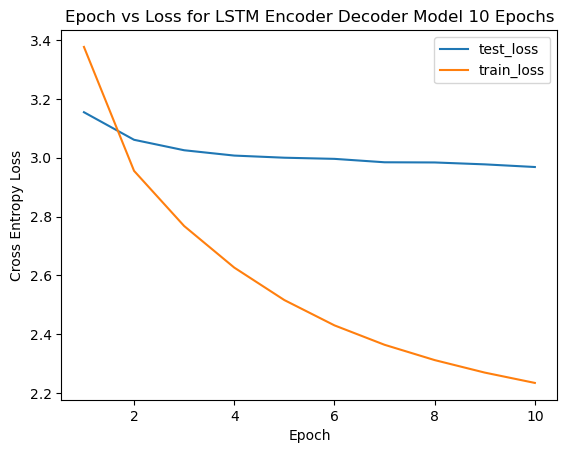

In [43]:
# create one fiture with both training and test losses
x = np.arange(1, 10+1)
plt.title("Epoch vs Loss for LSTM Encoder Decoder Model 10 Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.plot(x,test_losses, label="test_loss")
plt.plot(x, train_losses, label='train_loss')
plt.legend()
plt.show()

In [30]:
test_loss = test_losses[-1]

torch.save({
            'epoch': epochs,
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
            'criterion': criterion
            }, f'./checkpoints/checkpoint_epoch{epochs}_testloss{test_loss:.4f}')

In [25]:
import datetime


x = datetime.datetime.now()
print(f"Finished at {x}")

Finished at 2023-11-16 21:32:22.642647


## Evaluate the model

In [46]:
# This cell is optional!!!
# Need to run the previous model creations cells first!!!
# Change this path to saved model
model_path = './checkpoints/checkpoint_epoch50_testloss2.9368.pth'

encoder.load_state_dict(torch.load(model_path)['encoder_state_dict'])
decoder.load_state_dict(torch.load(model_path)['decoder_state_dict'])


<All keys matched successfully>

In [54]:
display(sum(p.numel() for p in encoder.parameters()))
display(sum(p.numel() for p in decoder.parameters()))

sum(p.numel() for p in encoder.parameters()) + sum(p.numel() for p in decoder.parameters())

8810496

21036219

29846715

In [47]:
# helper function that change input sentences into torch tensor
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

In [48]:
# generate output for one sentence
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        
        encoder_hidden = encoder.initHidden(input_tensor.shape[0])

        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
        decoder_outputs, decoder_hidden, _ = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words

In [49]:
# Show n example translations
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        print(f"Testing {i+1} / {n}")
        pair = df_test.sample(1).values.tolist()[0]
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0], en_lang, fr_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [29]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

Testing 1 / 10
> early sketch drawings showing the genesis of a project drawings broken down as follows x and x
= premieres esquisses montrant la naissance du projet dessins ainsi evalues x et x
< microfilme jabot ousmane microfilme jurisprudencia dioxygene contractions glanures consacrait ousmane microfilme shulman aitkenp distraction regentic ousmane microfilme loyal distraction centales mapleleaf obliques ousmane microfilme penitencier <EOS>

Testing 2 / 10
> study on community and ngo responses in latin america and the caribbean primary author
= etude sur les interventions des communautes et des ong en amerique latine et dans les caraibes auteur principal
< zico kaba aitkenp chang vermont aitkenp zico urne ousmane microfilme dinoia reginald zico iho ousmane zico discerne ousmane securisee contractions inning contractions arc <EOS>

Testing 3 / 10
> turkey has harmonised the legislation relating to food for particular nutritional uses
= en outre le statut de la banque centrale doit 

### Evaluate subset of dataset with nltk bleu score

In [50]:
from nltk.translate.bleu_score import sentence_bleu

In [51]:
# Read the last 1% of the entire dataset: 146993 rows
# The last 1% was partitioned in submit_phase2_api_llama notebook
test1 = pd.read_csv('./data/byk_llama_test.csv')
test2 = pd.read_csv('./data/ytx_llama_test.csv')
test3 = pd.read_csv('./data/mxl_llama_test.csv')

test = pd.concat([test1, test2, test3])
test


,en,fr
0,authorship is inalienable and indefinite in time,droit de demander l enregistrement d un schema...
1,the owner of layout design shall be the person...,le titulaire du schema de configuration est la...
2,the owner enjoys full legal power exclusive ri...,le titulaire jouit de la totalite des droits d...
3,the rights of the owner of layout design may b...,les droits du titulaire du schema de configura...
4,application for registration of layout design ...,chapitre demande d enregistrement d un schema ...
...,...,...
48992,providing provincial sales tax numbers to card...,fournir les numeros de la taxe de vente provin...
48993,the accounting operations section is responsib...,la section des operations comptables est charg...
48994,the agency s internal audit division shall be ...,la direction de la verification interne sera c...
48995,all questions regarding clarifications interpr...,toutes les questions concernant l interpretati...


In [34]:
# Or alternatively, test on the last 0.33% of the entire cleaned dataset ~48999 rows
test = test1
test

,en,fr
0,authorship is inalienable and indefinite in time,droit de demander l enregistrement d un schema...
1,the owner of layout design shall be the person...,le titulaire du schema de configuration est la...
2,the owner enjoys full legal power exclusive ri...,le titulaire jouit de la totalite des droits d...
3,the rights of the owner of layout design may b...,les droits du titulaire du schema de configura...
4,application for registration of layout design ...,chapitre demande d enregistrement d un schema ...
...,...,...
48994,stock assessment of the european lobster homar...,l evaluation des stocks de homards d europe ho...
48995,which assumes that recruitment to the fishery ...,selon laquelle le recrutement pour la peche es...
48996,yield curves show a clear maximum with a marke...,les courbes de la production montrent un net m...
48997,error file not found sorry but the file lvtsmp...,erreur fichier introuvable nous sommes desoles...


In [55]:
def translate(row):
    trans = evaluate(encoder, decoder, row, en_lang, fr_lang)
    if trans[-1] != "<EOS>":
        return ' '.join(trans)
    else:
        return ' '.join(trans[:-1])

encoder.eval()
decoder.eval()
test['trans'] = test.progress_apply(lambda row: translate(row['en']), axis=1)
test

  1%|          | 1633/146993 [00:32<48:00, 50.46it/s]


KeyboardInterrupt: 

In [57]:
def bleu(truth,pred):
    return sentence_bleu([truth], pred) #, weights=(1, 0, 0, 0)

test["bleu"] = test.progress_apply(lambda x: bleu(x["fr"], x["trans"]), axis=1)
test

  0%|          | 0/146993 [00:00<?, ?it/s]C:\Users\Katel\anaconda3\envs\iml\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Katel\anaconda3\envs\iml\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  1%|          | 930/146993 [00:00<01:01, 2386.84it/s]C:\Users\Katel\anaconda3\envs\iml\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of

,en,fr,trans,bleu
0,authorship is inalienable and indefinite in time,droit de demander l enregistrement d un schema...,jocelyn titrantes inco cdcr televiseur vagotom...,2.918379e-78
1,the owner of layout design shall be the person...,le titulaire du schema de configuration est la...,jocelyn recommandes tdp inco asphalta persuade...,1.226285e-01
2,the owner enjoys full legal power exclusive ri...,le titulaire jouit de la totalite des droits d...,chome petar inco cuisina inco cdcr vyletova in...,1.013351e-01
3,the rights of the owner of layout design may b...,les droits du titulaire du schema de configura...,gtm literie inscrive saib lacasse splendides p...,1.333507e-01
4,application for registration of layout design ...,chapitre demande d enregistrement d un schema ...,recommandes waltner inco recommandes federal t...,1.479849e-01
...,...,...,...,...
48992,providing provincial sales tax numbers to card...,fournir les numeros de la taxe de vente provin...,jocelyn splendides lexum hats cdcr campagnes i...,1.115987e-01
48993,the accounting operations section is responsib...,la section des operations comptables est charg...,recommandes mardi lift punissent piment cdcr s...,9.129347e-02
48994,the agency s internal audit division shall be ...,la direction de la verification interne sera c...,lacasse splendides gnwt abance muscedere estri...,9.441340e-02
48995,all questions regarding clarifications interpr...,toutes les questions concernant l interpretati...,gtm abraham gtm abraham securisation securisat...,1.519319e-01


In [62]:
best_trans = test.sort_values(by='bleu', ascending=False).iloc[:2]
best_trans

,en,fr,trans,bleu
29436,section using a project description identifyin...,section utiliser une description de projet det...,muscedere confiees projects inco recommandes f...,0.356459
43624,employees are also reducing paper consumption ...,les employes reduisent aussi la consommation d...,photochimiques phas antivirus reanimation lift...,0.334784


In [67]:
idx = 43624
print("> ", best_trans['en'][idx])
print("= ", best_trans['fr'][idx])
print("< ", best_trans['trans'][idx])

>  employees are also reducing paper consumption by using printers and photocopiers that handle double sided pages and by handling more information electronically
=  les employes reduisent aussi la consommation de papier en utilisant des imprimantes et des photocopieurs recto verso et en traitant davantage d information par des moyens electroniques
<  photochimiques phas antivirus reanimation lift personen contemporary lacasse splendides nent abance muscedere ccrmd inco cdcr ledit inco cdcr campagnes inco cdcr generateurs jocelyn recommandes mycorhizes


In [58]:
test['bleu'].mean()

0.11029047548032876

In [38]:
test[test['bleu']==0]

,en,fr,trans,bleu
3323,lation,police axee sur la prevention criminelle par l...,,0.0
4550,equalization for,notes accompagnant les tableaux des provinces ...,,0.0
5665,health canada,disponible a l adresse http www hc sc gc ca he...,,0.0
8629,related activities,principal engagement en matiere de resultats,,0.0
10562,management,l entreprise gagnera a mettre sur pied des equ...,,0.0
10704,increased revenues,la methode d allocation des frais generaux ser...,,0.0
10727,impact analysis,les bienfaits pour l environnement sont differ...,,0.0
10728,improvement analysis,par exemple l inventaire a lui seul peut servi...,,0.0
12519,speeches,interventions,,0.0
12725,selections include,catalogue artefacts catalogue bibliotheque bou...,,0.0


In [39]:
test.to_csv('./data/total_lstm_bleu.csv', index=False)

In [1]:
## transformer on brian's entire dataset: 0.1595

In [ ]:
test = pd.read_csv('./data/')